In [33]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D

In [34]:
#As specified in Table II of our paper, we confirm a signal exists only if activity is present in 2 out of 3 data points
#This function relabels any singal data points with activity 

def relabel_singles(df):
    #Relabeling the Mann-Kendall Signals both increasing and decreasing
    labels = ['increasing', 'decreasing']
    for l in labels:
        indx = df.index[df['MK Signal'] == l].tolist()
        for i in indx:
            if i < (df.shape[0]-2):

                #Store the two data points above and below the current data point
                before_row = df.iloc[i-1]
                after_row = df.iloc[i+1]
                before_row2 = df.iloc[i-2]
                after_row2 = df.iloc[i+2]

                #If none of the stored data points have activity relabel the current data point
                if (before_row['MK Signal'] != l) and (after_row['MK Signal'] != l) and (before_row2['MK Signal'] != l) and (after_row2['MK Signal'] != l):
                    row = df.iloc[i]
                    row['MK Signal'] = 'no trend'

    #Relabeling the control chart signals both above the UCL and below the LCL
    labels = ['above limits', 'below limits']
    for l in labels:
        indx = df.index[df['Control Limit Signal'] == l].tolist()
        for i in indx:
            if i < (df.shape[0]-2):
                before_row = df.iloc[i-1]
                after_row = df.iloc[i+1]
                before_row2 = df.iloc[i-2]
                after_row2 = df.iloc[i+2]

                if (before_row['Control Limit Signal'] != l) and (after_row['Control Limit Signal'] != l) and (before_row2['Control Limit Signal'] != l) and (after_row2['Control Limit Signal'] != l):
                    row = df.iloc[i]
                    row['Control Limit Signal'] = 'no trend'

In [35]:
#This function codes the signal labels as numerical values for the sake of generating figures
#0 = no signal
#1 = both a control chart and a Mann-Kendall signal exist
#2 = Increasing Mann-Kendall signal
#3 = Decreasing Mann-Kendall signal
#4 = Control chart above the UCL signal
#5 = Control chart below the LCL signal

def visualization_values(df):
    if (df['MK Signal'] != 'no trend') & (df['Control Limit Signal'] == 'above limits'):
        return 1
    elif (df['MK Signal'] != 'no trend') & (df['Control Limit Signal'] == 'below limits'):
        return 1
    elif df['MK Signal'] == 'increasing':
        return 2
    elif df['MK Signal'] == 'decreasing':
        return 3
    elif df['Control Limit Signal'] == 'above limits':
        return 4
    elif df['Control Limit Signal'] == 'below limits':
        return 5
    else:
        return 0

In [36]:
#Censorship measurement datasets do not collect data every single day, therefore, we can only identify activity on days where data is collected.
#For the sake of creating figures, we label days with no measurements based on the signal of the days before and after
#This function groups the signal results from each dataset based on country and fills in the dates with no measurements.

def clean_df_for_graph(country_code, dataset_array, date_df):

    current_df = date_df
    
    for d in dataset_array:
        #Reading in signals for each dataset for a given country
        temp_df = pd.read_csv('../results/' + country_code + '-' + d + '.csv', usecols = ['Start Date', 'MK Signal', 'Control Limit Signal'])
        relabel_singles(temp_df)
        temp_df[d] = temp_df.apply(visualization_values, axis=1)
        temp_df['Date'] = pd.to_datetime(temp_df['Start Date'], format='%Y-%m-%d')
        temp_df = temp_df.drop(columns=['Start Date', 'MK Signal', 'Control Limit Signal'])
    
        current_df = pd.merge(current_df, temp_df, on=['Date'], how='left')

    #Labeling dates with no measurements
    for d in range(len(dataset_array)):
        if pd.isna(current_df.at[0, dataset_array[d]]) or current_df.iloc[0, d+1] == 0:
            current_value = 0
            current_value_index = -1
        else:
            current_value = current_df.iloc[0, d+1]
            current_value_index = 0
        
        for i in range(len(current_df)):
            item = current_df.iloc[i, d+1]
            if pd.isna(current_df.at[i, dataset_array[d]]):
                current_df.iloc[i, d+1] = current_value
            elif item != current_value:
                if current_value_index != -1:
                    for j in range(current_value_index +1, i):
                        current_df.iloc[j, d+1] = 0
                    current_value = item
                    current_value_index = i
            else:
                current_value_index = i
        
        for j in range(current_value_index +1, len(current_df)):
            current_df.iloc[j, d+1] = 0

    return current_df


In [37]:
#Creating a figure of the signals found for each country

def create_figure(dataset_array, country_code, country_name, current_country_df):
    
    color_map = {0: np.array([255, 255, 255]), # neither
             1: np.array([124, 40, 125]), # both #7B287D
             2: np.array([34, 146, 164]), #MK increasing #2293a4
             3: np.array([255, 179, 15]), #MK decreasing ##ffb30f
             4: np.array([0, 56, 68]), # CC above #003844
             5: np.array([238, 109, 77])} # CC below #ee6d4d
    
    
    current_country_df = current_country_df.set_index(current_country_df['Date'])
    current_country_df = current_country_df.sort_index()
    current_country_df['date_name'] = current_country_df['Date'].dt.strftime('%-d %b %y')
    
    dates = current_country_df['date_name'].to_list()
    idx = []
    dates_current = []
    for i in range(0, len(dates), 30):
        idx.append(i)
        dates_current.append(str(dates[i]))
        
    temp = current_country_df[dataset_array]
    data = temp.to_numpy()
    dataT = np.transpose(data)
    
    data = np.ndarray(shape=(dataT.shape[0], dataT.shape[1], 3), dtype=int)
    for i in range(0, dataT.shape[0]):
        for j in range(0, dataT.shape[1]):
            data[i][j] = color_map[dataT[i][j]]
    
    legend_elements = [Line2D([0], [0], color='#2293a4', lw=0, marker='s', markersize=20, label='MK increasing'),
                      Line2D([0], [0], color='#003844', lw=0, marker='s', markersize=20, label='Control chart above'),
                      Line2D([0], [0], color='#ffb30f', lw=0, marker='s', markersize=20, label='MK decreasing'),
                      Line2D([0], [0], color='#ee6d4d', lw=0, marker='s', markersize=20, label='Control chart below'),
                      Line2D([0], [0], color='#7B287D', lw=0, marker='s', markersize=20, label='Both Signal')]

    
    fig, ax = plt.subplots(figsize=(35, 8))
    
                       
    ax.grid(which='minor', color='black', axis='y', linestyle='-', linewidth=1)
    ax.grid(which='major', axis='x', color='black', linestyle='-', linewidth=1)
    
    if country_code == 'mm':
        ax.set_yticks([0.5, 1.5, 2.5, 3.5])
        ax.set_yticks([0, 1, 2, 3], minor=True)
        ax.imshow(data, extent=[0,len(df['Date']),0,4], aspect='auto', interpolation='nearest')
        row_labels = ['HTTPS', 'HTTP', 'SATELLITE', 'OONI']
    
    elif country_code == 'cn':
        ax.set_yticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5])
        ax.set_yticks([0, 1, 2, 3, 4, 5], minor=True)
        ax.imshow(data, extent=[0,len(df['Date']),0,6], aspect='auto', interpolation='nearest')
        row_labels = ['GFWATCH', 'TOR', 'HTTPS', 'HTTP', 'SATELLITE', 'OONI']
    
    else:
        ax.set_yticks([0.5, 1.5, 2.5, 3.5, 4.5])
        ax.set_yticks([0, 1, 2, 3, 4], minor=True)
        ax.imshow(data, extent=[0,len(df['Date']),0,5], aspect='auto', interpolation='nearest')
        row_labels = ['TOR', 'HTTPS', 'HTTP', 'SATELLITE', 'OONI']
    
    ax.set_yticklabels(row_labels, fontsize=30)
    ax.set_xticks(range(df.shape[0]))#, minor=True)
    ax.set_xticks(idx)
    ax.set_xticklabels(dates_current, rotation=30, fontsize=30)
    ax.set_title(country_name + " Signals", fontsize=40, weight='bold')
                   
    ax.legend(handles=legend_elements, bbox_to_anchor=(0.15, 1.1), ncol=3, loc='lower left', fontsize=40)
    plt.show()
    #plt.savefig("signals-" + country_code + ".png", bbox_inches="tight", pad_inches=1)

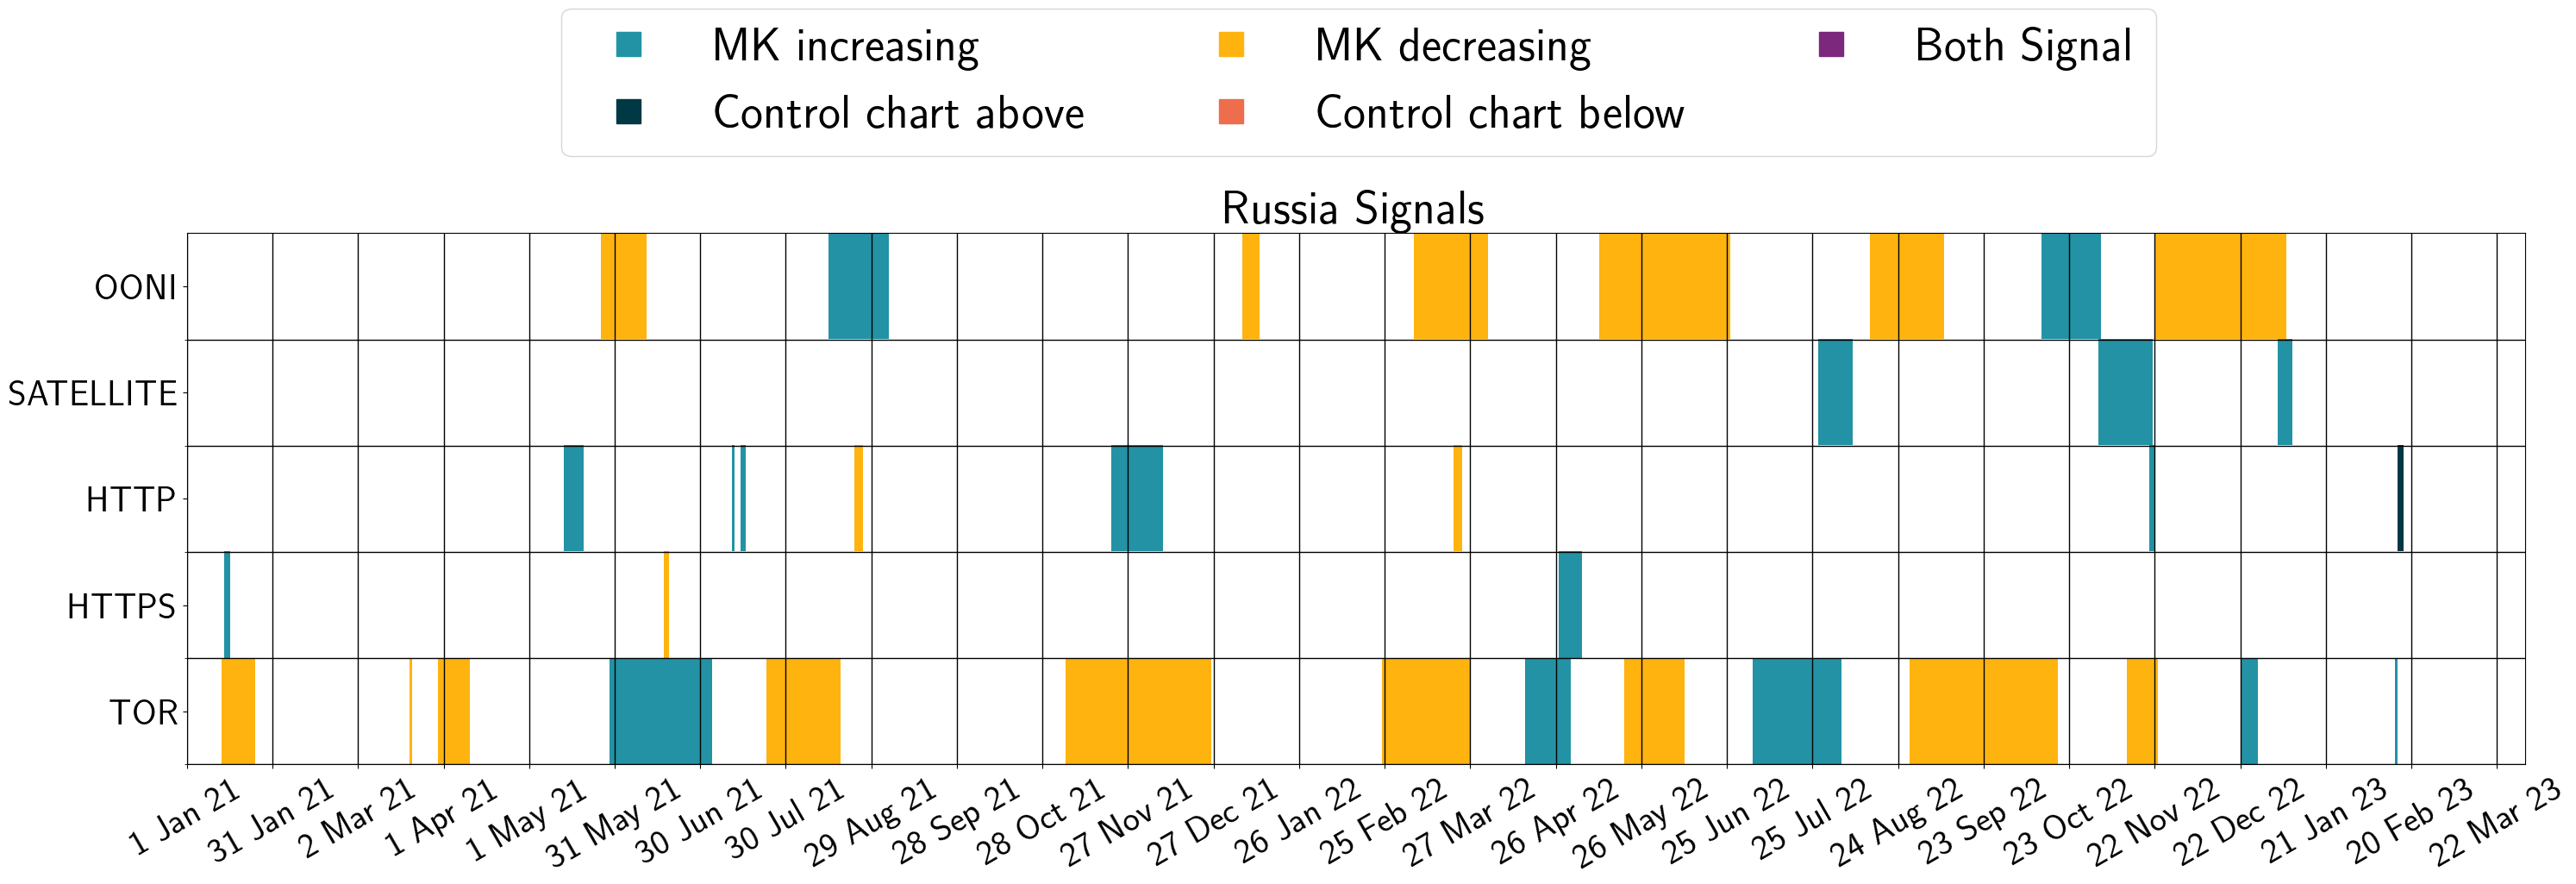

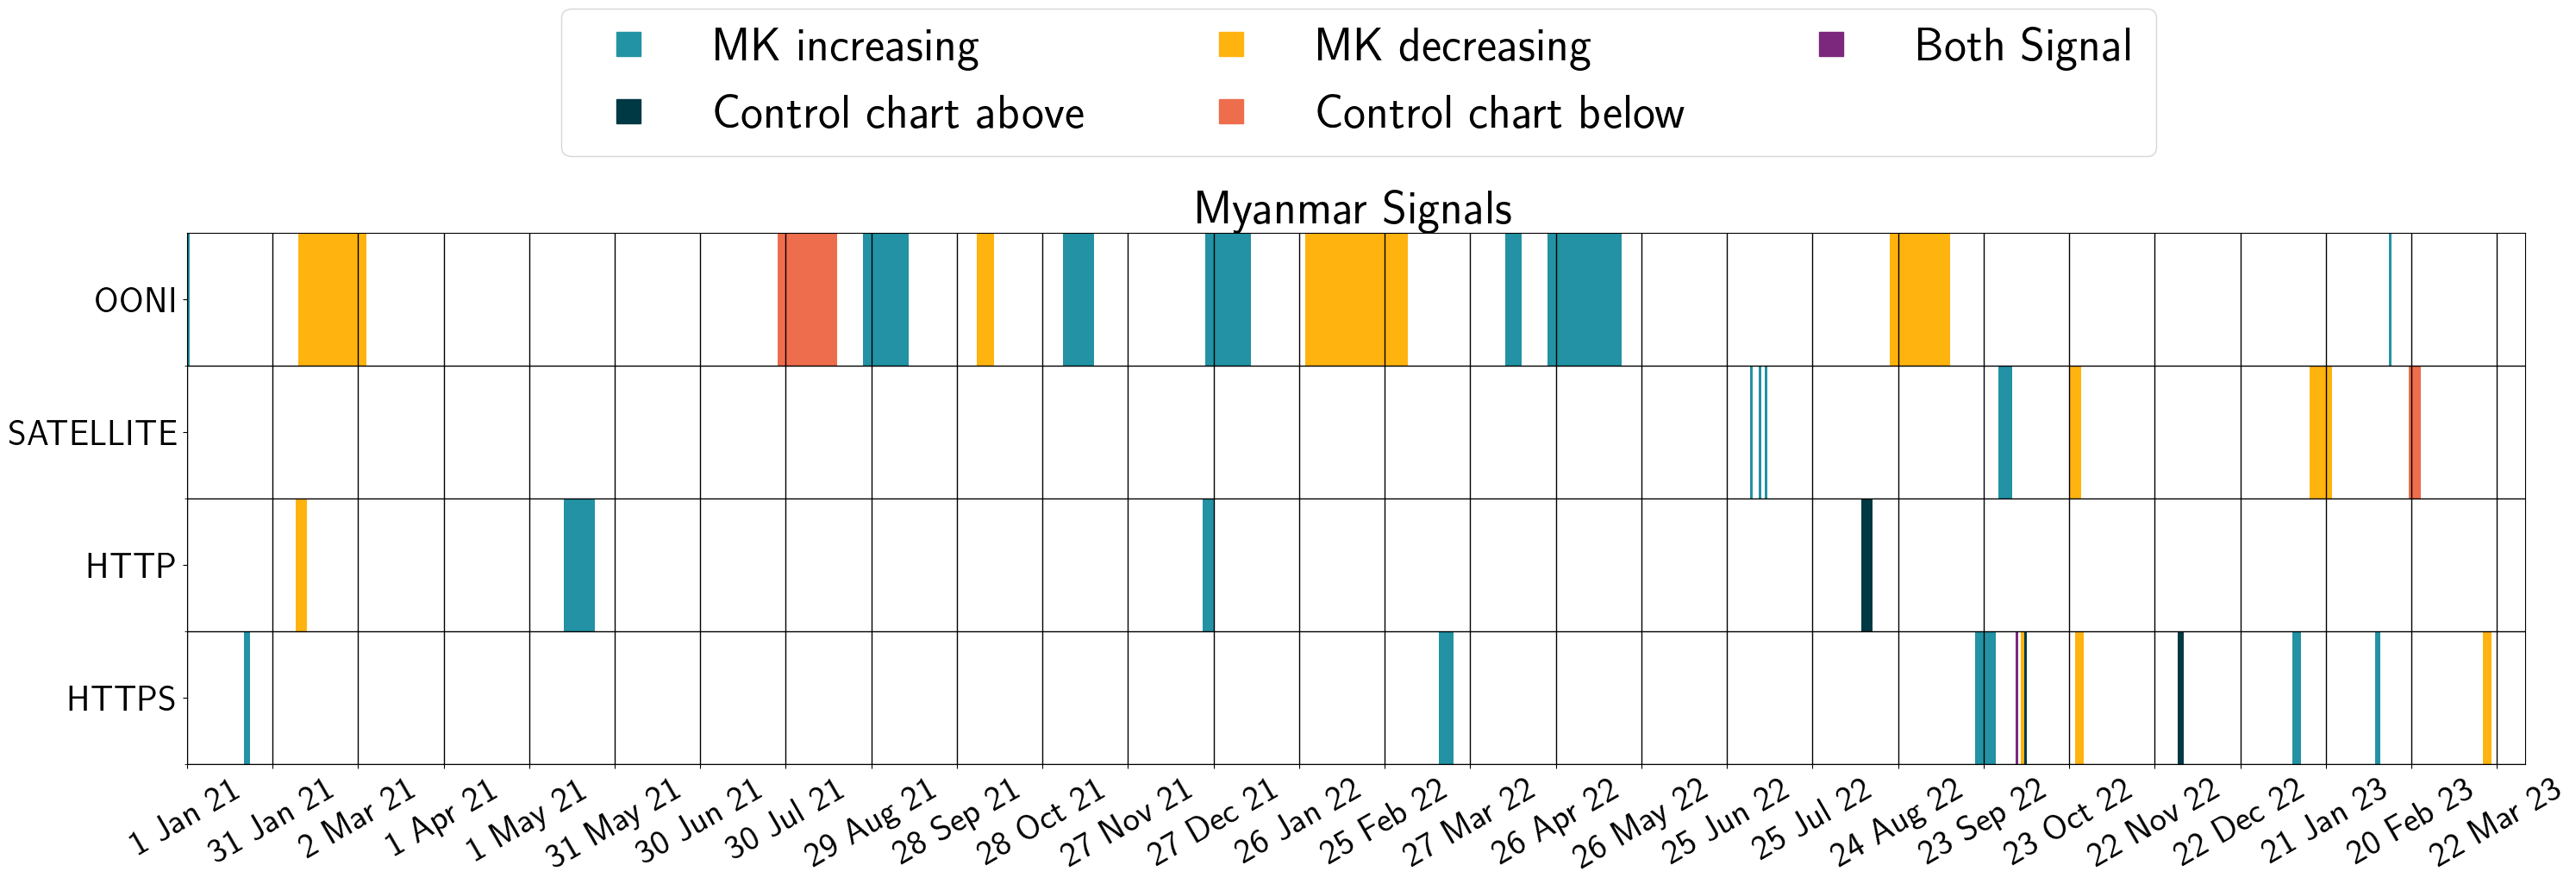

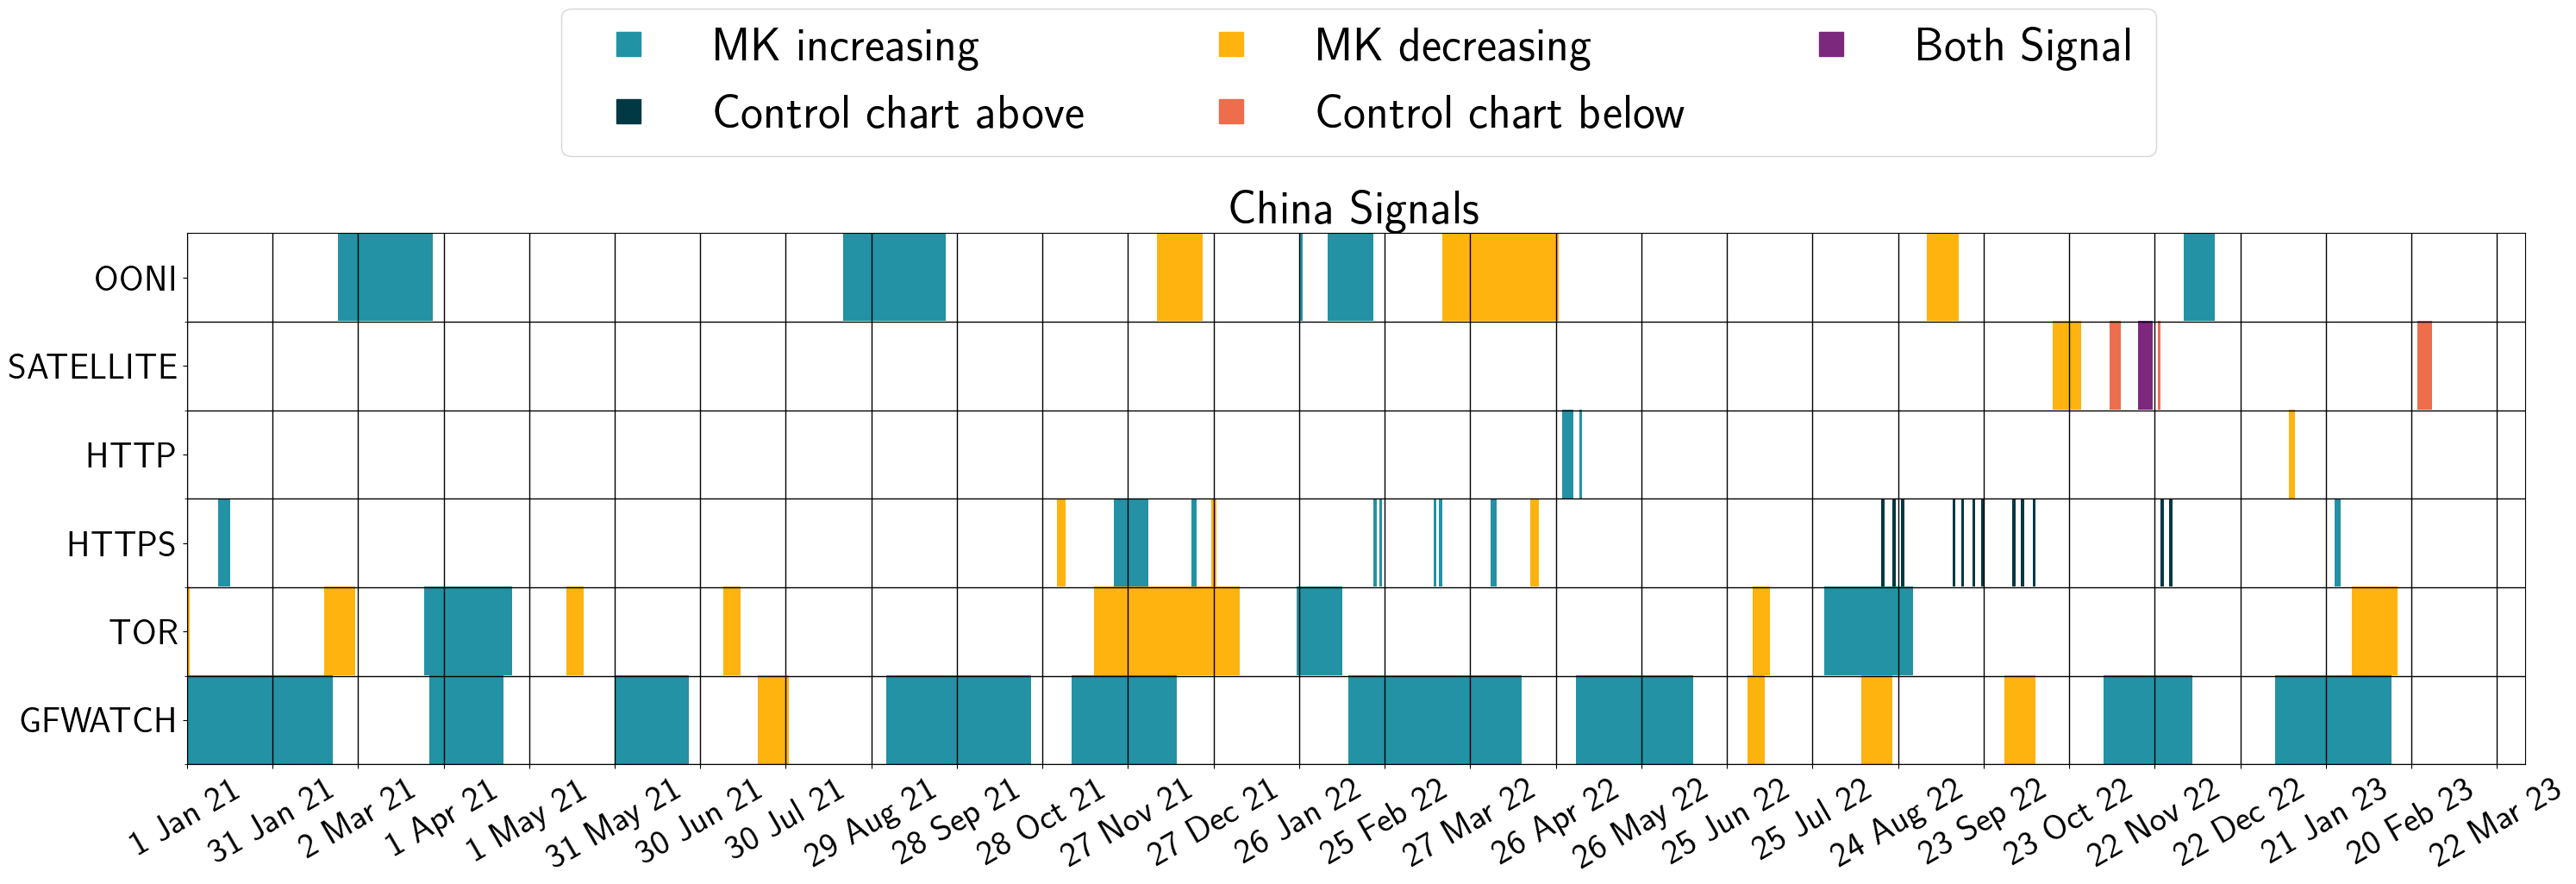

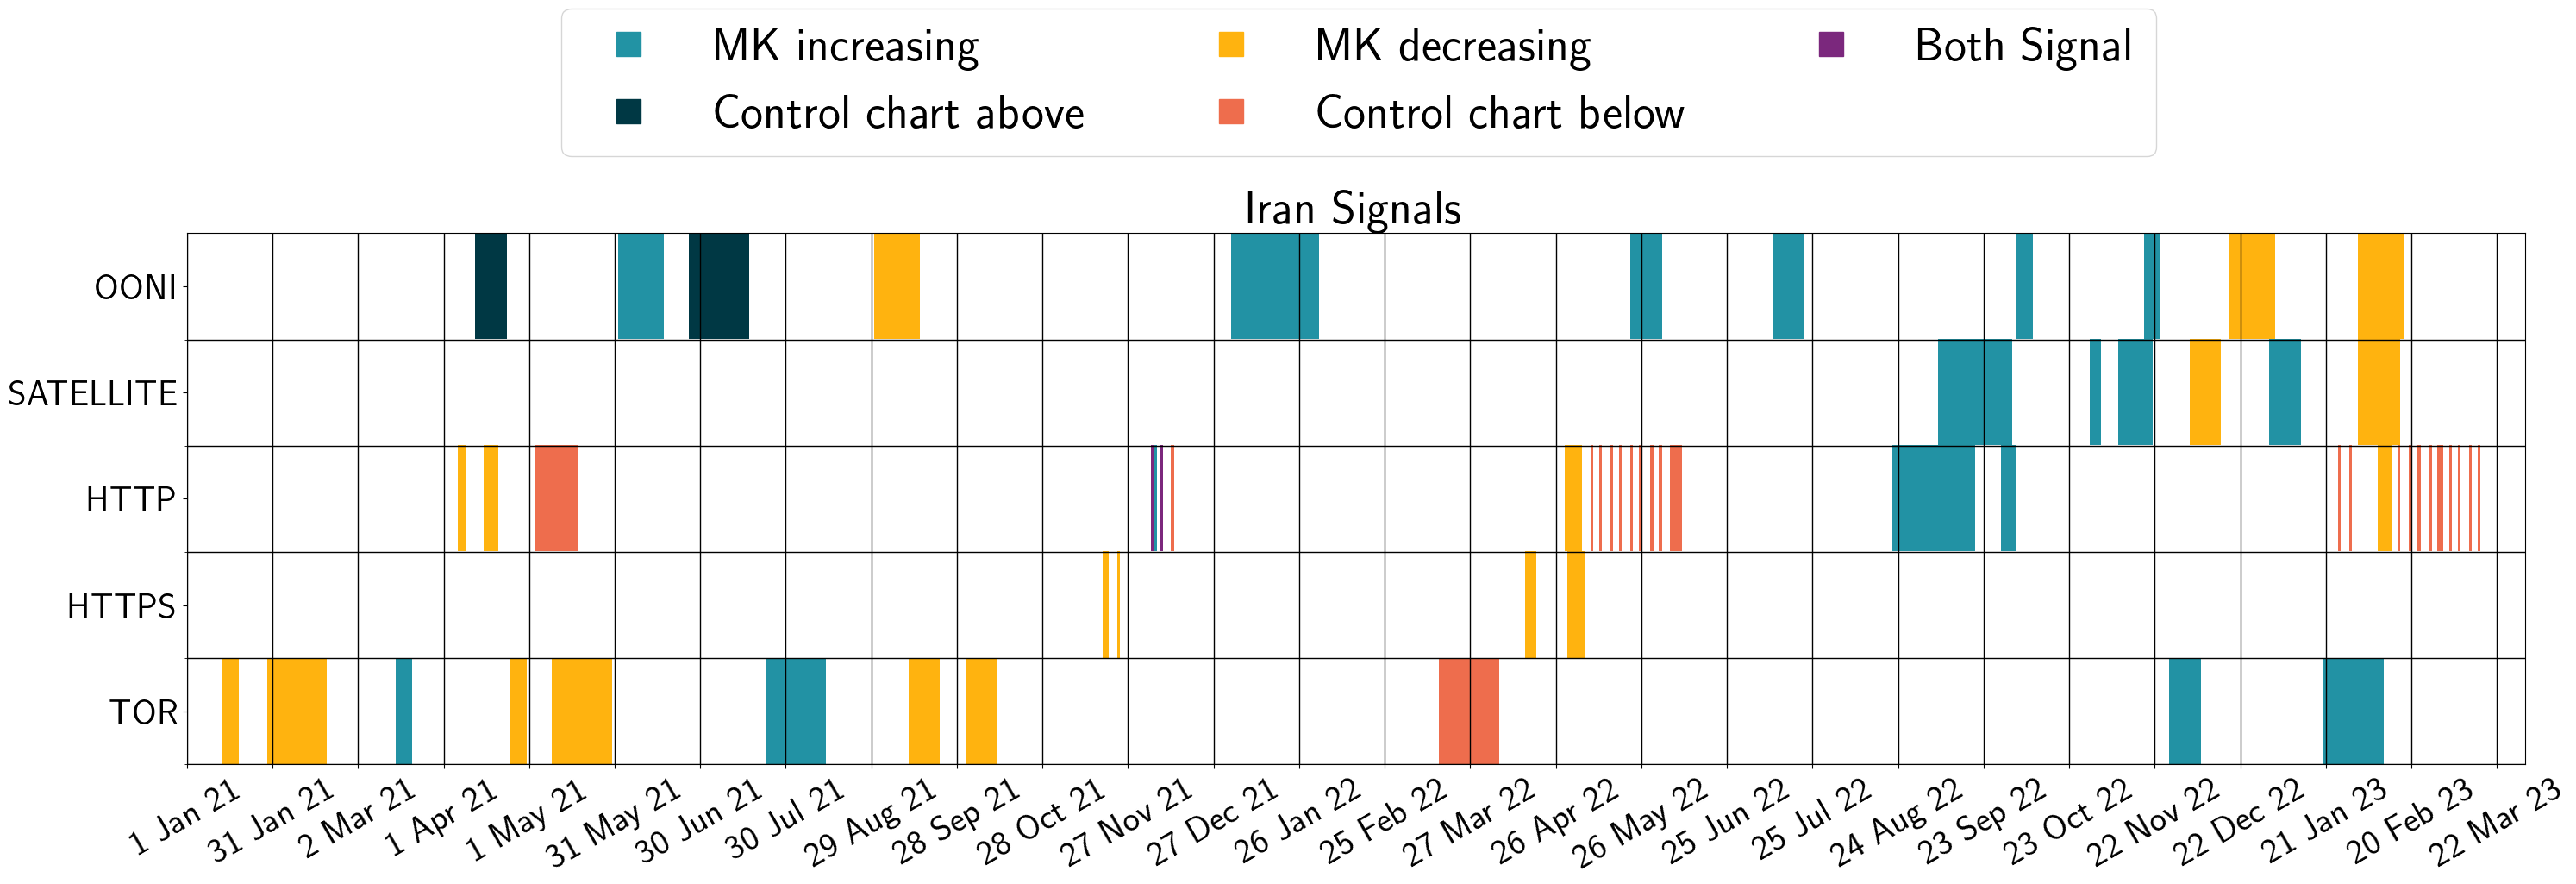

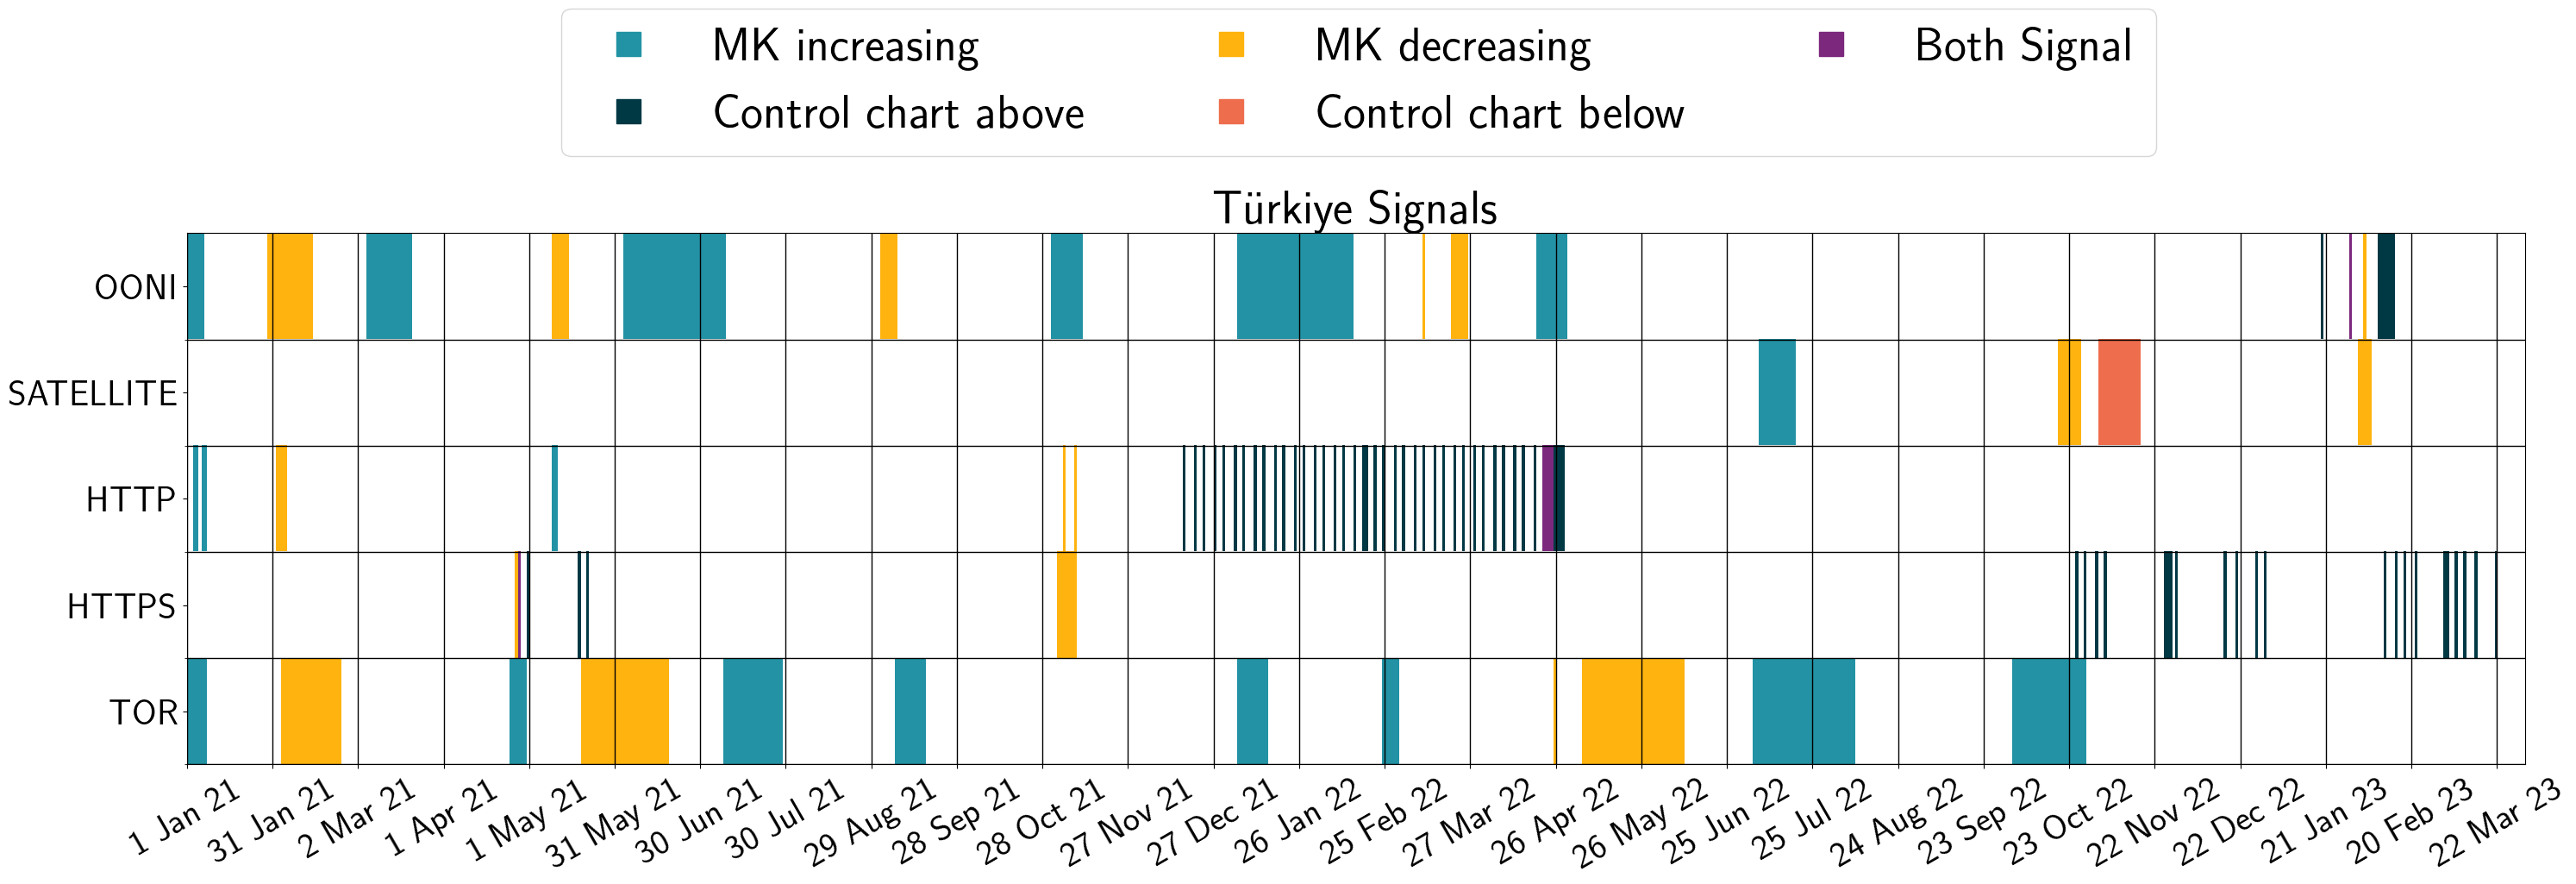

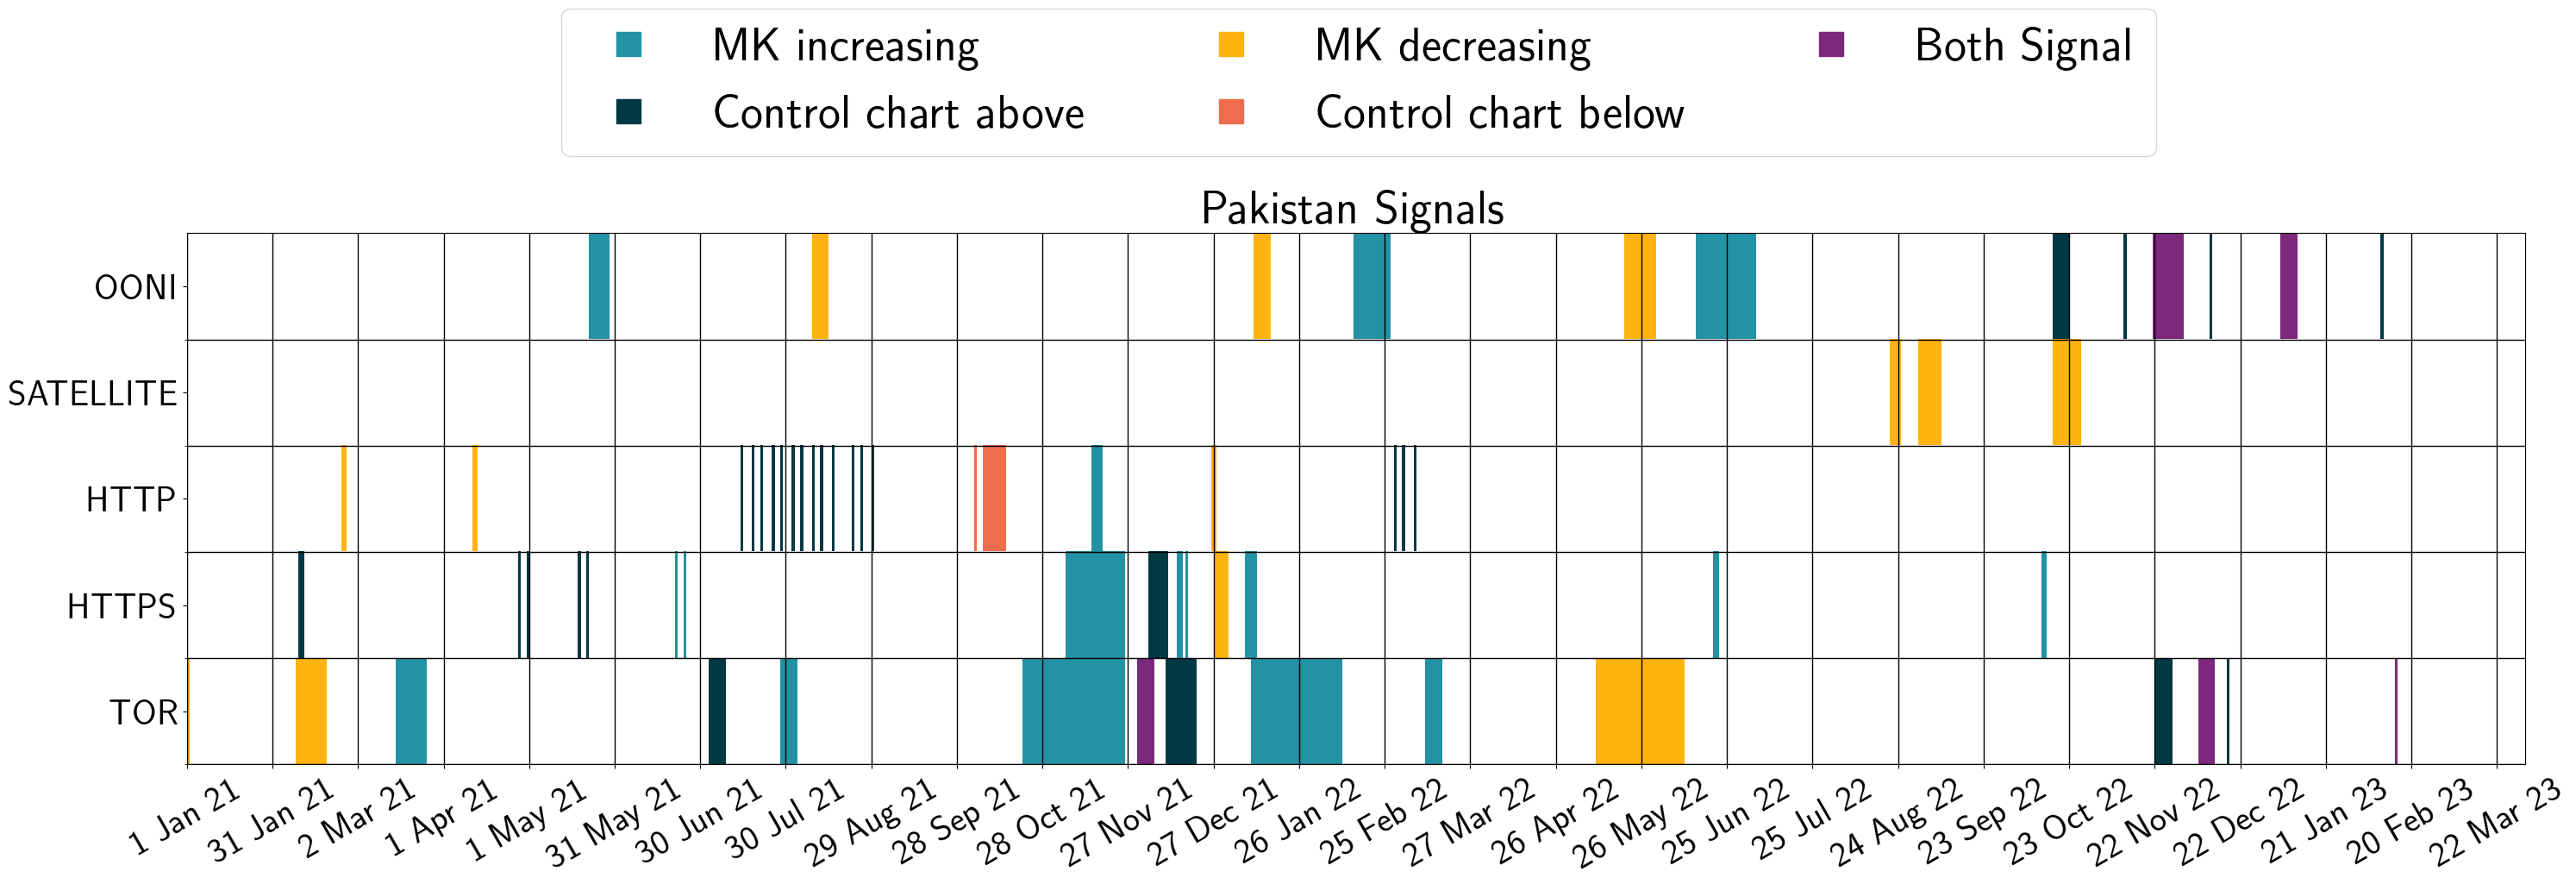

In [38]:
#Cleaning, labeling and generating figures for the signal data from each country.
#Figures 5-10 in the paper are zoomed in subsections of the following figures.
#Additionally, these figures in full can be found in Appendix B of the paper.

dates = pd.read_csv('../data/dates.csv')
dates['Date'] = pd.to_datetime(dates['Date'], format='%Y-%m-%d')

countries = ['ru', 'mm', 'cn', 'ir', 'tr', 'pk']
country_names = ['Russia', 'Myanmar', 'China', 'Iran', 'Türkiye', 'Pakistan']

for i in range(len(countries)):
    cc = countries[i]
    
    #Tor data is not available in Myanmar
    if cc == 'mm':
        dataset = ['ooni', 'satellite', 'http', 'https']

    #GFWatch data is only available in China
    elif cc == 'cn':
        dataset = ['ooni', 'satellite', 'http', 'https', 'tor', 'gfwatch']
    else:
        dataset = ['ooni', 'satellite', 'http', 'https', 'tor']

    df = clean_df_for_graph(cc, dataset, dates)
    create_figure(dataset, cc, country_names[i], df)